# Basic LSTM Implementation

## Introduction
**Author**: Roxanne Lee <br>
**Objective**: To explore implementation of a basic LSTM model with PyTorch <br>
**Dataset**: [Airline Passenger Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) <br>

## Import libraries

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Data Preparation

In [15]:
# Obtain data
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(data_url, parse_dates=['Month'])
passenger_data = df.iloc[:,1:2].values.astype(float)

# Normalize data
mm = MinMaxScaler(feature_range=(0, 1))
passenger_data = mm.fit_transform(passenger_data)

# Train test split
test_size = 12 #using last 12 months as the test data
train_size = len(passenger_data) - test_size

### Define data conversion method

In [16]:
def convert_data(data, look_back=1):
	x, y = [], []
	for i in range(len(data) - look_back - 1):
		a = data[i:(i+look_back), 0]
		x.append(a)
		y.append(data[i+look_back, 0])
	return np.array(x), np.array(y)

- `convert_data` is a method which converts data values where if x is the data samples starting at time (t), then y would be the target timestamp data samples at time (t+`look_back`). 
- `look_back` is the period of timestamps used to predict the target timestamp
- References: [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

### Convert data

In [17]:
x_data, y_data = convert_data(passenger_data)
x_train, y_train = convert_data(passenger_data[:-test_size])
x_test, y_test = convert_data(passenger_data[-test_size:])

### Define custom dataset

In [18]:
class PassengerDataset(Dataset):
	def __init__(self, x, y):
		# convert to torch.FloatTensor with automatic differentiation
		self.y = Variable(torch.tensor(y, dtype=torch.float32))
		self.x = Variable(torch.tensor(x, dtype=torch.float32))
		self.len = self.x.shape[0]

	def __len__(self):
		return self.len

	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

`PassengerDataset` is a custom dataset subclass of the PyTorch `Dataset` class. <br>
The main use is to transform `numpy.ndarray` objects into `torch.Tensorflow` objects to prep for use in dataloading <br>
References: [PyTorch custom dataset tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

### Dataset and data loading

In [19]:
# Obtaining dataset
full_dataset = PassengerDataset(x_data, y_data)
train_dataset = PassengerDataset(x_train, y_train)

# Loading dataset
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 64)

## Build the Basic LSTM module

In [20]:
class BasicLSTM(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers = 1, output_size = 1):
		super(BasicLSTM, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.output_size = output_size
		
		self.lstm = nn.LSTM(num_layers=num_layers, input_size=input_size, 
						hidden_size=hidden_size, batch_first=True)
		
		self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

	def forward(self, x_input):
		# Initialize hidden state
		h_0 = Variable(torch.zeros(self.num_layers, x_input.size(0), self.hidden_size))
		
		# Initialize cell state
		c_0 = Variable(torch.zeros(self.num_layers, x_input.size(0), self.hidden_size))
		
		# Propagate input through LSTM
		out, (h_n, c_n) = self.lstm(x_input, (h_0, c_0))

		# Pass LSTM output to the linear layer
		predictions = self.linear(torch.relu(out))

		return predictions

`BasicLSTM`, subclass of the PyTorch `nn.module` class, is our custom LSTM module for running predictions. <br>
- `input_size` : Size of features in the current input
- `hidden_size` : Number of features in the hidden state
- `num_layers` : Number of recurrent layers of stacked LSTMs
- `output_size` : Size of output sample
##### References
- [PyTorch tutorial - Sequence Models and Long Short-Term Memory Networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
- [PyTorch tutorial - Build the Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [PyTorch nn.LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- [PyTorch nn.Linear documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)


## Training

In [21]:
num_epochs = 1500
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1
output_size = 1

lstm = BasicLSTM(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
	for i, data in enumerate(train_loader):
		y_prediction = lstm(data[:][0].view(-1, hidden_size, 1)).reshape(-1)

		# Zero the gradients
		optimizer.zero_grad()

		# Compute loss
		loss = loss_function(y_prediction, data[:][1])

		# Perform backward pass
		loss.backward()

		# Perform optimization
		optimizer.step()

	# Print statistics
	if epoch % 100 == 0:
		print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.92063
Epoch: 100, loss: 0.02387
Epoch: 200, loss: 0.00141
Epoch: 300, loss: 0.00166
Epoch: 400, loss: 0.00067
Epoch: 500, loss: 0.00032
Epoch: 600, loss: 0.00005
Epoch: 700, loss: 0.00543
Epoch: 800, loss: 0.00313
Epoch: 900, loss: 0.00203
Epoch: 1000, loss: 0.00010
Epoch: 1100, loss: 0.01437
Epoch: 1200, loss: 0.00277
Epoch: 1300, loss: 0.00206
Epoch: 1400, loss: 0.00316


## Testing and Predictions

In [22]:
lstm.eval()
train_predict = lstm(full_dataset[:][0].view(-1 ,hidden_size, 1)).reshape(-1)

# Numpy conversion
data_predict = train_predict.data.numpy()
dataY_plot = full_dataset[:][1].data.numpy()

# Inverse normalization
data_predict_inverse = mm.inverse_transform(data_predict.reshape(-1,1))
dataY_plot_inverse = mm.inverse_transform(dataY_plot.reshape(-1,1))


### Visualization

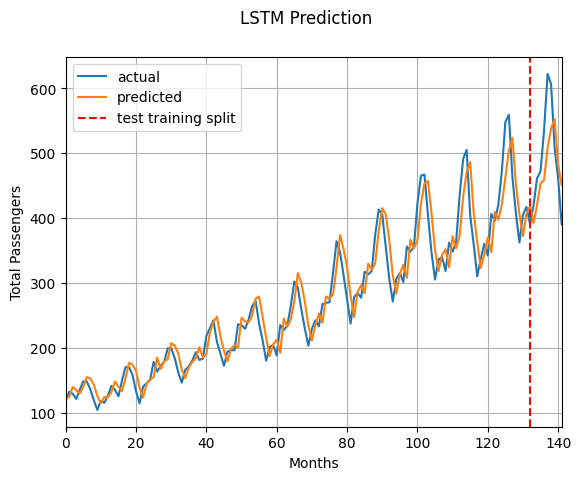

In [23]:
plt.plot(dataY_plot_inverse, label='actual')
plt.plot(data_predict_inverse, label='predicted')
plt.axvline(x=train_size, c='r', linestyle='--', label='test training split')
plt.autoscale(axis='x', tight=True)
plt.suptitle('LSTM Prediction')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.legend()
plt.show()